In [1]:
import numpy as np
from KL_optimization import alternating_kl_projection_log_nd
from Beta_optimization import alternating_beta_projection_log_nd
import matplotlib.pyplot as plt

In [2]:
def kl_divergence(p, empirical):
    """Compute the KL divergence between p and empirical distribution."""
    return np.sum(p * np.log((p) / (empirical)))

In [3]:
def sample_empirical(true_pi, num_samples):
    """
    Draws `num_samples` from the discrete distribution `true_pi`
    and returns an empirical probability tensor of the same shape,
    using your original flatten/unique/count logic.
    """
    # flatten the true distribution
    flat_probs = true_pi.flatten()
    
    # generation of empirical distribution from the true distribution
    picks = np.random.choice(len(flat_probs), size=num_samples, p=flat_probs)
    emp   = np.zeros_like(flat_probs)
    uniq, cnts = np.unique(picks, return_counts=True)
    emp[uniq] = cnts / num_samples
    
    # reshape back to the original tensor shape
    return emp.reshape(true_pi.shape)

In [4]:
def sample_matrix(alpha, beta=0.1, seed=None):
    """
    Sample a random 3×2 probability matrix `x` such that:
      - x[0,0] = alpha
      - all entries >= beta
      - sum(x) = 1

    Parameters:
        alpha : float
            Fixed value for x[0,0]. Must satisfy 0 <= alpha <= 1 - 5*beta.
        beta : float, default=0.1
            Minimum value for all other entries.
        seed : int or None
            Random seed for reproducibility.

    Returns:
        x : ndarray of shape (3,2)
            The sampled probability matrix.
        p : ndarray of shape (3,)
            Row sums of x (marginal distribution over rows).
        q : ndarray of shape (2,)
            Column sums of x (marginal distribution over columns).
    """
    if seed is not None:
        np.random.seed(seed)

    # Validate inputs
    n_slots = 3*2 - 1  # total entries minus the fixed one
    if not (0 <= alpha <= 1 - n_slots * beta):
        raise ValueError(f"alpha must be in [0, {1 - n_slots * beta}], got {alpha}")

    # Initialize matrix and reserve the first entry
    x = np.empty((3, 2), dtype=float)
    x[0, 0] = alpha
    remaining_budget = 1.0 - alpha

    # Indices of the remaining entries, in an order that respects future bounds
    fill_order = [(1, 0), (0, 1), (2, 0), (1, 1), (2, 1)]
    slots_left = len(fill_order)

    # Fill all but the last entry
    for (i, j) in fill_order[:-1]:
        max_val = remaining_budget - (slots_left - 1) * beta
        if max_val < beta:
            raise ValueError(
                f"Not enough budget to allocate at least {beta} to each of the {slots_left} slots; "
                f"remaining_budget={remaining_budget:.4f}, beta={beta}")
        x[i, j] = np.random.uniform(beta, max_val)
        remaining_budget -= x[i, j]
        slots_left -= 1

    # Last entry takes all remaining budget
    last_i, last_j = fill_order[-1]
    if remaining_budget < beta:
        raise ValueError(
            f"Remaining budget {remaining_budget:.4f} is below beta {beta}")
    x[last_i, last_j] = remaining_budget

    # Compute marginals
    p = x.sum(axis=1)  # row sums
    q = x.sum(axis=0)  # column sums
    return x, p, q


In [5]:
# Parameters
target_trials = 1000
num_samples   = 50
num_matrices  = 1
alpha         = 0.01
beta_sampling = 0.1

# epsilon grid
eps_range = np.linspace(0.01, 0.1, num=10)

# beta-projection parameters to compare
beta_list = [1.1, 1.2, 1.3]

In [6]:
# Sample true distributions
matrix_samples = [sample_matrix(alpha, beta_sampling, seed=i) for i in range(num_matrices)]

In [7]:
# Calculating projections, keeping track of three statistics:
# Mean of [0,0] element;
# Amount of zeros in projection distribution
# KL divergence value between projected and true distribution
for idx, (true_pi, marg1, marg2) in enumerate(matrix_samples, start=1):
    print(f"\n=== Matrix {idx}/{num_matrices} ===")
    print("True matrix (true_pi):")
    print(true_pi)

    # stats containers per beta
    stats = {
        'kl_mean00': [],
        'kl_zero00': [],
        'kl_meandiv': [],
        # for each beta in beta_list, we keep lists of mean00, zero00, meandiv
        'beta_mean00': {b: [] for b in beta_list},
        'beta_zero00': {b: [] for b in beta_list},
        'beta_meandiv': {b: [] for b in beta_list},
    }

    for eps in eps_range:
        # KL-projection stats at this epsilon
        kl_vals00 = []
        kl_divs   = []
        kl_zeros  = 0

        # collect for each beta
        beta_vals00   = {b: [] for b in beta_list}
        beta_divs     = {b: [] for b in beta_list}
        beta_zeros    = {b: 0 for b in beta_list}

        for _ in range(target_trials):
            # generation of empirical distribution from the true distribution
            pi_hat = sample_empirical(true_pi, num_samples)

            # KL projection
            proj_kl = alternating_kl_projection_log_nd(
                pi_hat, marginals=[marg1, marg2], num_iters=100,
                replace_zeros=True, epsilon=eps
            )
            kl_vals00.append(proj_kl[0, 0])
            kl_divs.append(kl_divergence(proj_kl, true_pi))
            kl_zeros += (proj_kl[0, 0] == 0)

            # Beta projections for each beta in beta_list
            for b in beta_list:
                proj_bt = alternating_beta_projection_log_nd(
                    pi_hat, marginals=[marg1, marg2], beta=b,
                    num_iters=1, full_cycles=50,
                    replace_zeros=True, epsilon=eps
                )
                beta_vals00[b].append(proj_bt[0, 0])
                beta_divs[b].append(kl_divergence(proj_bt, true_pi))
                beta_zeros[b] += (proj_bt[0, 0] == 0)

        # summarize KL
        stats['kl_mean00'].append(np.mean(kl_vals00))
        stats['kl_zero00'].append(kl_zeros)
        stats['kl_meandiv'].append(np.mean(kl_divs))

        # summarize each beta
        for b in beta_list:
            stats['beta_mean00'][b].append(np.mean(beta_vals00[b]))
            stats['beta_zero00'][b].append(beta_zeros[b])
            stats['beta_meandiv'][b].append(np.mean(beta_divs[b]))

        # print summary for this epsilon
        summary = (
            f"eps={eps:.4f} | KL: mean00={stats['kl_mean00'][-1]:.6f}, zeros={stats['kl_zero00'][-1]}, "
            f"div={stats['kl_meandiv'][-1]:.6f}"
        )
        for b in beta_list:
            summary += (
                f" || β={b}: mean00={stats['beta_mean00'][b][-1]:.6f}, "
                f"zeros={stats['beta_zero00'][b][-1]}, "
                f"div={stats['beta_meandiv'][b][-1]:.6f}"
            )
        print(summary)


=== Matrix 1/1 ===
True matrix (true_pi):
[[0.01       0.25811505]
 [0.36891862 0.11362891]
 [0.1379538  0.11138362]]
eps=0.0100 | KL: mean00=0.015615, zeros=0, div=0.016617 || β=1.1: mean00=0.015692, zeros=0, div=0.016656 || β=1.2: mean00=0.015777, zeros=0, div=0.016946 || β=1.3: mean00=0.015857, zeros=0, div=0.017525
eps=0.0200 | KL: mean00=0.020768, zeros=0, div=0.019240 || β=1.1: mean00=0.020723, zeros=0, div=0.019300 || β=1.2: mean00=0.020648, zeros=0, div=0.019561 || β=1.3: mean00=0.020529, zeros=0, div=0.020049
eps=0.0300 | KL: mean00=0.025722, zeros=0, div=0.024781 || β=1.1: mean00=0.025519, zeros=0, div=0.024641 || β=1.2: mean00=0.025271, zeros=0, div=0.024656 || β=1.3: mean00=0.024967, zeros=0, div=0.024849
eps=0.0400 | KL: mean00=0.029265, zeros=0, div=0.028794 || β=1.1: mean00=0.028879, zeros=0, div=0.028245 || β=1.2: mean00=0.028442, zeros=0, div=0.027842 || β=1.3: mean00=0.027946, zeros=0, div=0.027605
eps=0.0500 | KL: mean00=0.032323, zeros=0, div=0.034686 || β=1.1: mea

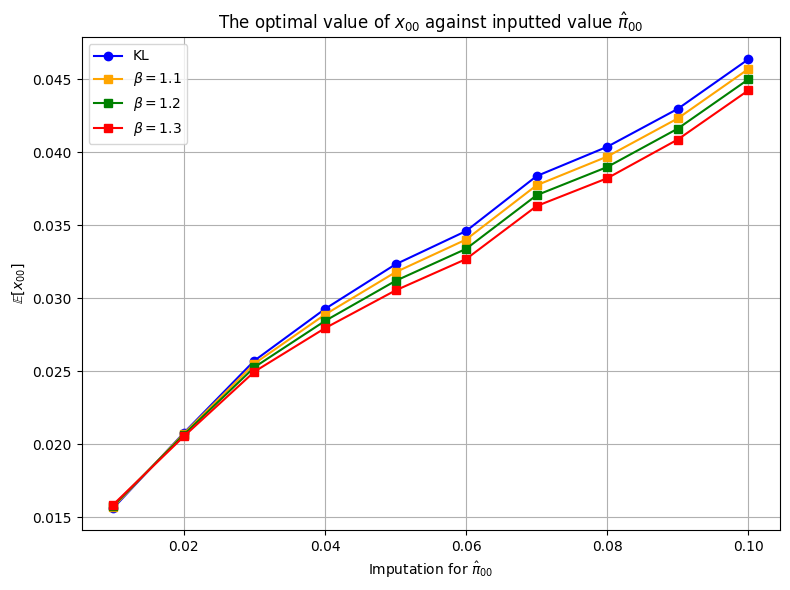

In [8]:
# Separate plot for Mean [0,0] comparison with β in legend, then save to file
# Define the colour for each method
beta_colors = ['orange', 'green', 'red']
# build a dict just for β → colour
beta_color_map = dict(zip(beta_list, beta_colors))

plt.figure(figsize=(8, 6))
plt.plot(eps_range, stats['kl_mean00'], 'o-', label='KL', color='blue')
for b in beta_list:
    plt.plot(
        eps_range, 
        stats['beta_mean00'][b], 
        marker='s', 
        linestyle='-', 
        label=rf'$\beta={b}$',
        color=beta_color_map[b]
    )
plt.xlabel(r'Imputation for $\hat\pi_{00}$')
plt.ylabel(r'$\mathbb{E}[x_{00}]$')
plt.title(r'The optimal value of $x_{00}$ against inputted value $\hat\pi_{00}$')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig('optimal_x00_vs_pi_hat00.png')

plt.show()


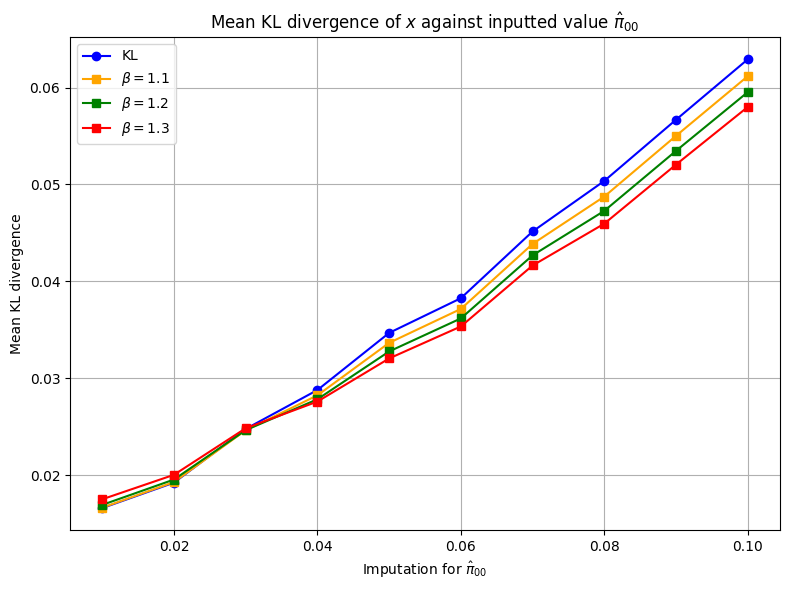

In [9]:
plt.figure(figsize=(8, 6))
# Plot KL-projection mean KL divergence
plt.plot(eps_range, stats['kl_meandiv'], 'o-', label='KL', color='blue')

# Plot Beta-projection mean KL divergence for each β
for b in beta_list:
    plt.plot(
        eps_range,
        stats['beta_meandiv'][b],
        marker='s',
        linestyle='-',
        label=rf'$\beta={b}$',
        color=beta_color_map[b]
    )

plt.xlabel(r'Imputation for $\hat\pi_{00}$')
plt.ylabel(r'Mean KL divergence')
plt.title(r'Mean KL divergence of $x$ against inputted value $\hat\pi_{00}$')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig('mean_KL_vs_pi_hat00.png')

plt.show()
